In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shahbozsharafzoda
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 382MB/s]


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device available",device)


Device available cuda


In [4]:
# By default we for each dataset, we have train and validation. Our task will be to go though all and split into 3: train, validation, test

In [5]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head() # Visualizing the first 5 rows

,image_paths,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/flickr_cat_...,cat
3,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [6]:
print(data_df['labels'].unique())

['cat' 'wild' 'dog']


In [7]:
train = data_df.sample(frac=0.7) # this means for training purpose, we want to use 70% of the whole data
test = data_df.drop(train.index) # 30 % of the data will go to test

val = test.sample(frac=0.5) # on the other hand half of that 30 % will go to validation
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels']) # here we are asking label encoder to give the values for the labels we have in the dataset(cat,dog,wild)

# cat=0, dog=1, wild=2, it could be in any order

# transform will make all the images to have the same properties: size, data type
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)

    ]
)

In [13]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataset.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label



In [14]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [15]:
train_dataset.__getitem__(2)

(tensor([[[0.4275, 0.3608, 0.4392,  ..., 0.0353, 0.0275, 0.0235],
          [0.5176, 0.3961, 0.4392,  ..., 0.0314, 0.0275, 0.0392],
          [0.5882, 0.5059, 0.4941,  ..., 0.0431, 0.0667, 0.1020],
          ...,
          [0.7922, 0.8588, 0.8353,  ..., 0.9843, 0.9843, 0.9804],
          [0.7608, 0.8510, 0.8157,  ..., 0.9725, 0.9529, 0.9647],
          [0.7137, 0.8392, 0.7922,  ..., 0.9569, 0.9412, 0.9255]],
 
         [[0.3529, 0.3647, 0.4863,  ..., 0.0353, 0.0275, 0.0235],
          [0.5098, 0.4275, 0.4902,  ..., 0.0314, 0.0314, 0.0431],
          [0.6157, 0.5529, 0.5373,  ..., 0.0431, 0.0667, 0.1059],
          ...,
          [0.6118, 0.6784, 0.6549,  ..., 0.7765, 0.7843, 0.7765],
          [0.5686, 0.6667, 0.6235,  ..., 0.7373, 0.7216, 0.7451],
          [0.5137, 0.6392, 0.5922,  ..., 0.7137, 0.6941, 0.6941]],
 
         [[0.0353, 0.0824, 0.1020,  ..., 0.0392, 0.0235, 0.0157],
          [0.1216, 0.0784, 0.0784,  ..., 0.0314, 0.0196, 0.0235],
          [0.1373, 0.1137, 0.0941,  ...,

In [16]:
# we want to know 0 corresponds to which label

label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

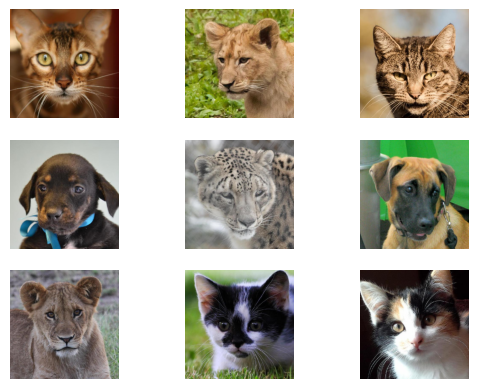

In [19]:
# lets visualize images

n_rows = 3
n_cols = 3

x, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)['image_paths'].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()




In [20]:
# now lets set our hyper parameters

LR = 1e-4 # learning rate
BATCH_SIZE = 16 # batch size
EPOCHS = 10 #epochs


In [21]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# now we will build the model

class Net(nn.Module):
  def __init__(self):
    super.__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3)


# the main purpose of convolution is to do, edge detection

